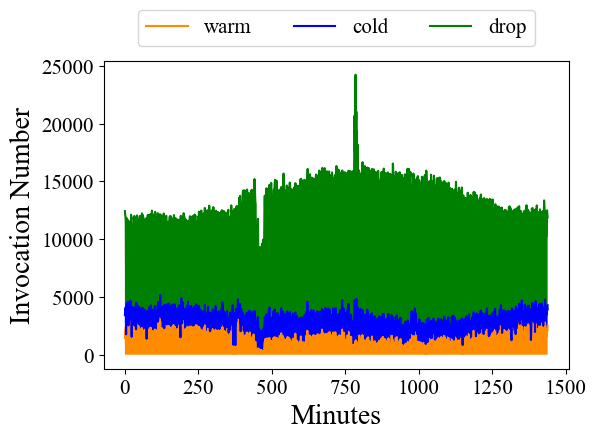

In [68]:
#LRU时每分钟warm，cold，drop图、

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.rc('font',family='Times New Roman')
plt.rc('font',size = 15)
def read1440Data(df:pd.DataFrame, name:str, suffix:str):
    row_index = name + suffix
    vals = df.loc[row_index,"0":"1439"].values
    return vals

df = pd.read_csv("C:/Users/Administrator/Desktop/Cloud/drawDataSets/representative/results/perMinute.csv")

X = np.array([i for i in range(1440)])

df["full_name"] = df.apply(lambda row: row['name'] + row['state'], axis=1)
df.index = df["full_name"]

perMinWarm = read1440Data(df,"All","Warm")
perMinCold = read1440Data(df,"All","Cold")
perMinDrop = read1440Data(df,"All","TTLDrop")

warm = perMinWarm
cold = np.add(warm,perMinCold)
drop = np.add(cold,perMinDrop)

fig,ax = plt.subplots(figsize=(6,4),dpi=100)

plt.xlabel('Minutes', size = 20)
plt.ylabel('Invocation Number', size = 20)

plt.plot(X,warm,"darkorange")
plt.plot(X,cold,"blue")
plt.plot(X,drop,"g")

plt.fill_between(X.tolist(),0,warm.tolist(),facecolor = 'darkorange')
plt.fill_between(X.tolist(),warm.tolist(),cold.tolist(),facecolor = 'blue')
plt.fill_between(X.tolist(),cold.tolist(),drop.tolist(),facecolor = 'green')

plt.legend(labels = ('warm','cold','drop'),ncol=3 ,loc = 'upper center',bbox_to_anchor=(0.5,1.2))
plt.savefig('../Pics/LRU_all.pdf',bbox_inches = 'tight')


C:\Users\Administrator\AppData\Local\Temp\ipykernel_18676\2234463528.py:13: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  sums = df.sum(axis=1)


[  10388.   20624. 1852207. 2578936.]
[  76387.   57516. 1345451. 1917899.]
[ 1665578.  3473657.  6317965. 13955838.]


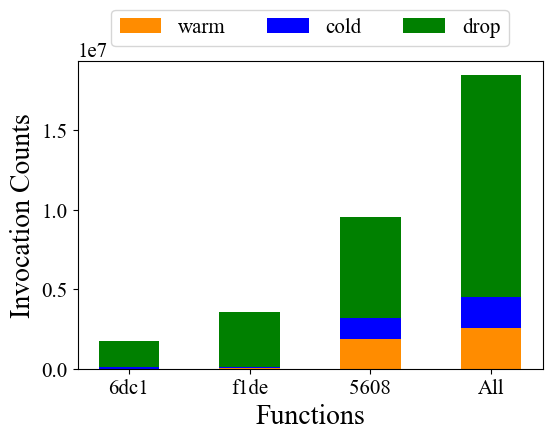

In [69]:
#每个函数的调用结果记录X 1-400， Y：invoke res
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.rc('font',family='Times New Roman')
plt.rc('font',size = 15)
high_cost_function_names = ["6dc157fa79f808bd7cf577af09efaee2dad035d658e549d4219e705a181d8917",
                            "f1de419dc75ea0f629deaf936e0b65934cbf2bc444ffd7b3116e3a19dd108f11",
                            "5608f70ad5c4f89e83b01f37bdabd7b89f79338b34776128d68676d83cd3de15",
                            ]

df = pd.read_csv("C:/Users/Administrator/Desktop/Cloud/drawDataSets/representative/results/invokeRes.csv")
sums = df.sum(axis=1)
df['sum'] = sums
df.index = df["name"]
df = df.sort_values(by='sum',ascending=False)

warm_sum = df['cold'].sum()
cold_sum = df['warm'].sum()
drop_sum = df["queue full drop"].sum() + df['ttl drop'].sum()

warmList = np.array([])
coldList = np.array([])
dropList = np.array([])
for name in high_cost_function_names:
    warm = df.loc[name,'warm']
    cold = df.loc[name,'cold']
    drop = df.loc[name,'queue full drop'] + df.loc[name,'ttl drop']
    warmList = np.append(warmList,warm)
    coldList = np.append(coldList,cold)
    dropList = np.append(dropList,drop)

warmList = np.append(warmList,warm_sum)
coldList = np.append(coldList,cold_sum)
dropList = np.append(dropList,drop_sum)

print(warmList)
print(coldList)
print(dropList)

x = [name[0:4] for name in high_cost_function_names]
x.append("All")


fig,ax = plt.subplots(figsize=(6,4),dpi=100)
plt.bar(x, warmList, width=0.5 ,label = 'warm',color='darkorange')
plt.bar(x, coldList, width=0.5 ,label = 'cold',color='blue',bottom= warmList )
plt.bar(x, dropList, width=0.5 ,label = 'drop',color='green', bottom= warmList+coldList)

plt.xlabel("Functions",fontproperties = 'Times New Roman', size = 20)
plt.ylabel("Invocation Counts",fontproperties = 'Times New Roman', size = 20)
plt.legend(ncol=3 ,loc = 'upper center',bbox_to_anchor=(0.5,1.2))
plt.savefig('../Pics/bar_high_freq.pdf',bbox_inches = 'tight')


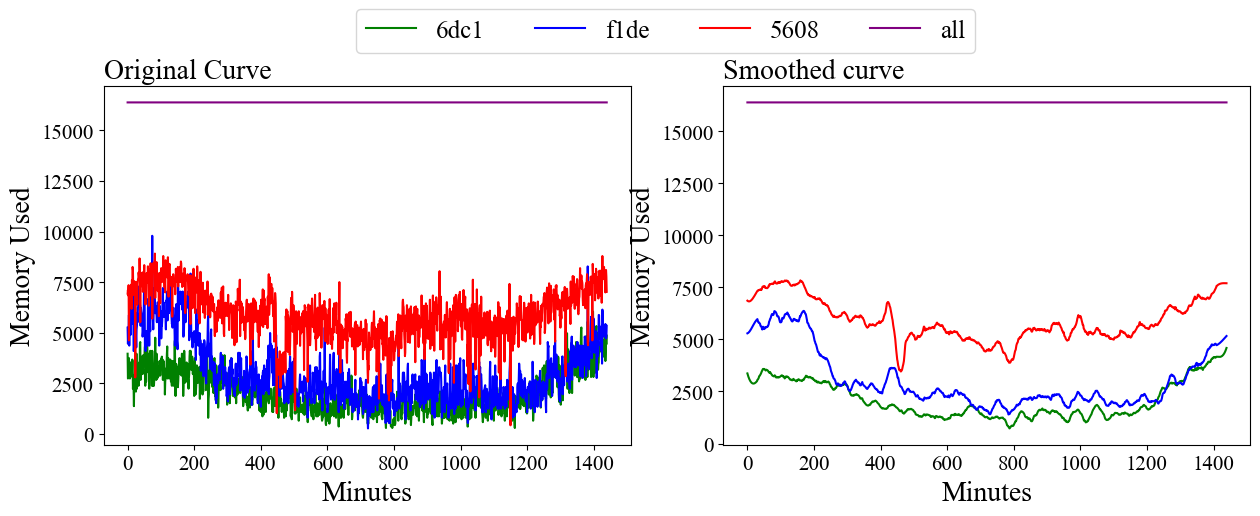

In [77]:
#高请求函数的容器在1440分钟内每分钟的内存占用
#LRU时每分钟warm，cold，drop图、

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
from scipy.signal import savgol_filter
plt.rc('font',family='Times New Roman')
plt.rc('font',size = 15)

high_cost_function_names = ["6dc157fa79f808bd7cf577af09efaee2dad035d658e549d4219e705a181d8917",
                            "f1de419dc75ea0f629deaf936e0b65934cbf2bc444ffd7b3116e3a19dd108f11",
                            "5608f70ad5c4f89e83b01f37bdabd7b89f79338b34776128d68676d83cd3de15",
                            ]


def read1440Data(df:pd.DataFrame, name:str, suffix:str):
    row_index = name + suffix
    vals = df.loc[row_index,"0":"1439"].values
    return vals

df = pd.read_csv("C:/Users/Administrator/Desktop/Cloud/drawDataSets/representative/results/mem.csv")

X = np.array([i for i in range(1440)])

df["full_name"] = df.apply(lambda row: row['name'] + row['value'], axis=1)
df.index = df["full_name"]

arrays = []
for name in high_cost_function_names:
    perMinData = read1440Data(df,name,"Max")
    arrays.append(perMinData)
    
perMinAverage = read1440Data(df,"All","Max")
arrays.append(perMinAverage)
colors = ['green','blue','red','purple']

fig,ax = plt.subplots(1,2, figsize=(12,4),dpi=100)
fig.tight_layout(pad=0.1, w_pad=2.1, h_pad=4)

ax[0].set_xlabel('Minutes',fontproperties = 'Times New Roman', size = 20)
ax[0].set_ylabel('Memory Used',fontproperties = 'Times New Roman', size = 20)
for (y,color) in zip(arrays,colors):
    ax[0].plot(X,y,color)
ax[0].set_title("Original Curve",loc='left',fontproperties = 'Times New Roman',size = 20)



ax[1].set_xlabel('Minutes',fontproperties = 'Times New Roman', size = 20)
ax[1].set_ylabel('Memory Used',fontproperties = 'Times New Roman', size = 20)
for (y,color) in zip(arrays,colors):
    y_smooth = savgol_filter(y,60,3)
    ax[1].plot(X,y_smooth,color)

ax[1].set_title("Smoothed curve",loc='left',fontproperties = 'Times New Roman',size = 20)
fig.legend(labels= ['6dc1','f1de','5608','all'],ncol=4 ,loc = 'upper center',fontsize = 18,bbox_to_anchor=(0.5,1.2))
plt.savefig('../Pics/high_freq_mem.pdf',bbox_inches = 'tight')


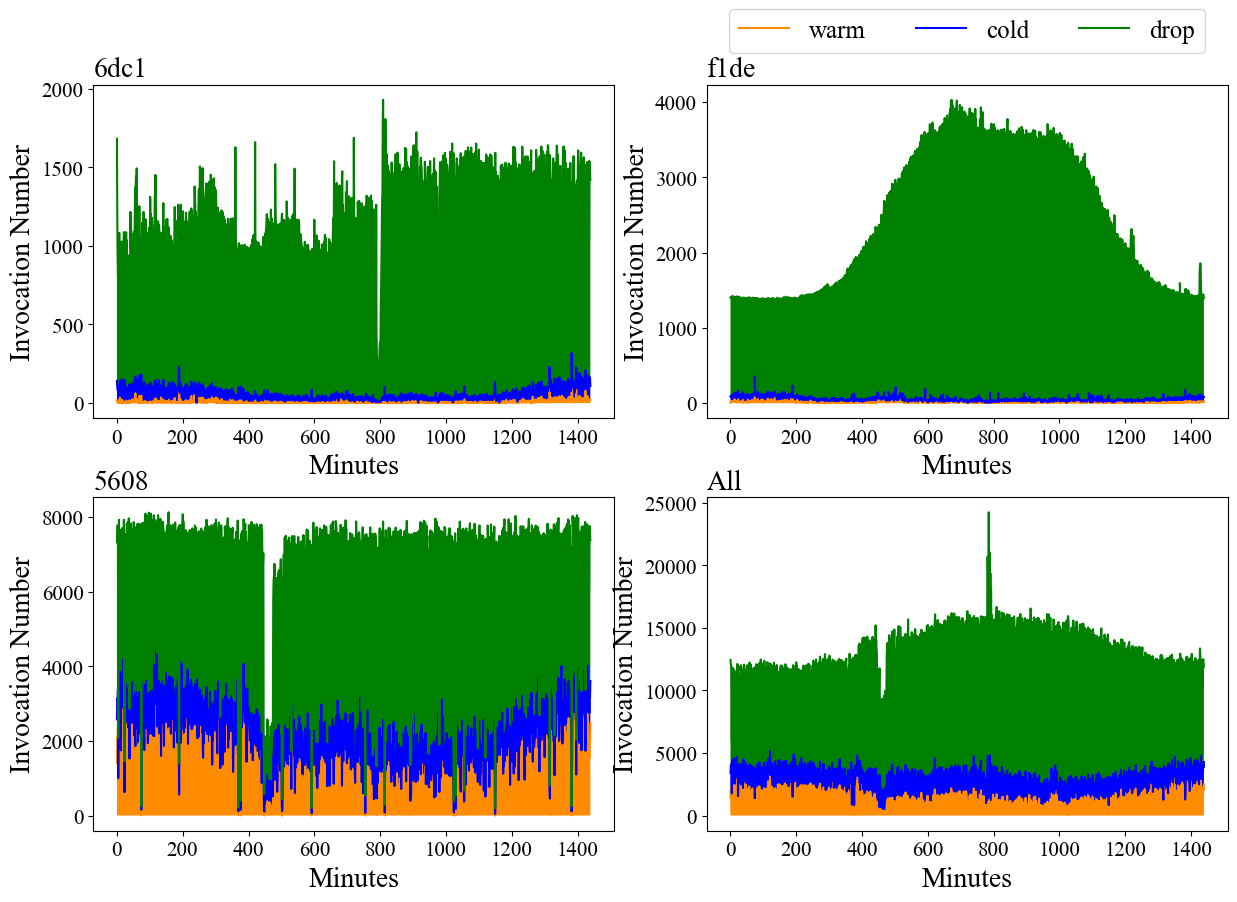

In [83]:
#高频函数在1-1440分钟每分钟热启动，冷启动和超时的次数
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.rc('font',family='Times New Roman')
plt.rc('font',size = 15)
names =["6dc157fa79f808bd7cf577af09efaee2dad035d658e549d4219e705a181d8917",
        "f1de419dc75ea0f629deaf936e0b65934cbf2bc444ffd7b3116e3a19dd108f11",
        "5608f70ad5c4f89e83b01f37bdabd7b89f79338b34776128d68676d83cd3de15",
        "All"
        ]

def read1440Data(df:pd.DataFrame, name:str, suffix:str):
    row_index = name + suffix
    vals = df.loc[row_index,"0":"1439"].values
    return vals

df = pd.read_csv("C:/Users/Administrator/Desktop/Cloud/drawDataSets/representative/results/perMinute.csv")

X = np.array([i for i in range(1440)])

df["full_name"] = df.apply(lambda row: row['name'] + row['state'], axis=1)
df.index = df["full_name"]

fig,ax = plt.subplots(2,2, figsize=(12,8),dpi=100)
fig.tight_layout(pad=0.4, w_pad=2.1, h_pad=2)

index = 0
for name in names:
    perMinWarm = read1440Data(df,name,"Warm")
    perMinCold = read1440Data(df,name,"Cold")
    perMinDrop = read1440Data(df,name,"TTLDrop")
    warm = perMinWarm
    cold = np.add(warm,perMinCold)
    drop = np.add(cold,perMinDrop)
    
    if index == 0:
        axe = ax[0][0]
    if index == 1:
        axe = ax[0][1]
    if index == 2:
        axe = ax[1][0]
    if index == 3:
        axe = ax[1][1]
    

    
    
    axe.set_xlabel('Minutes',fontproperties = 'Times New Roman', size = 20)
    axe.set_ylabel('Invocation Number',fontproperties = 'Times New Roman', size = 20)
    title = name[0:3]
    if len(name) > 3 :
        title = name[0:4]
    axe.set_title(title,loc='left',fontproperties = 'Times New Roman', size = 20)
    
    axe.plot(X,warm,"darkorange")
    axe.plot(X,cold,"blue")
    axe.plot(X,drop,"g")

    axe.fill_between(X.tolist(),0,warm.tolist(),facecolor = 'darkorange')
    axe.fill_between(X.tolist(),warm.tolist(),cold.tolist(),facecolor = 'blue')
    axe.fill_between(X.tolist(),cold.tolist(),drop.tolist(),facecolor = 'green')
    
    index = index + 1

plt.legend(labels = ('warm','cold','drop'),ncol=3 ,loc = 'upper center',bbox_to_anchor=(0.5,2.5),fontsize = 18)
plt.savefig('../Pics/high_freq_LRU_1440.pdf',bbox_inches = 'tight')

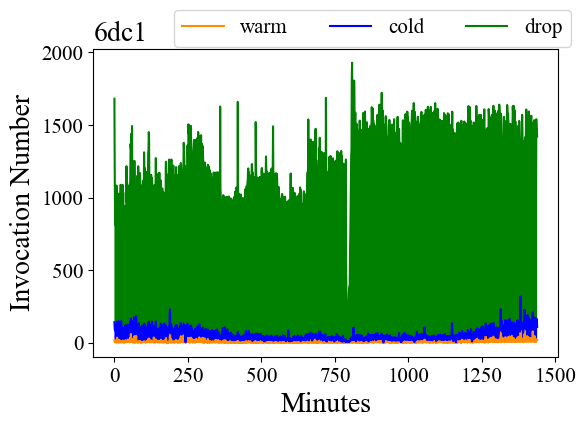

<Figure size 640x480 with 0 Axes>

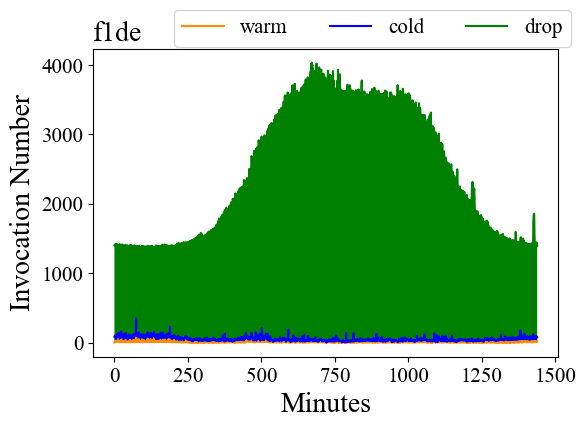

<Figure size 640x480 with 0 Axes>

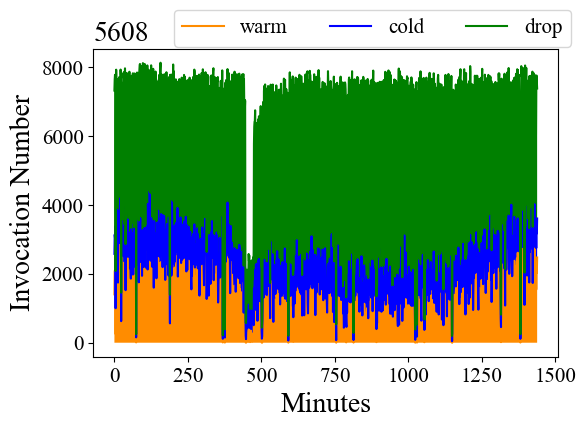

<Figure size 640x480 with 0 Axes>

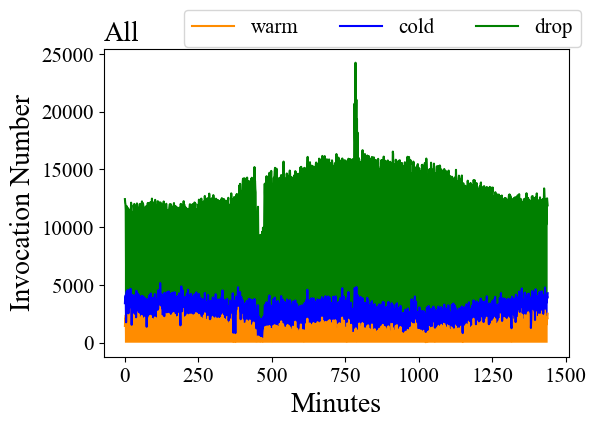

<Figure size 640x480 with 0 Axes>

In [10]:
#高频函数在1-1440分钟每分钟热启动，冷启动和超时的次数
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.rc('font',family='Times New Roman')
plt.rc('font',size = 15)
names =["6dc157fa79f808bd7cf577af09efaee2dad035d658e549d4219e705a181d8917",
        "f1de419dc75ea0f629deaf936e0b65934cbf2bc444ffd7b3116e3a19dd108f11",
        "5608f70ad5c4f89e83b01f37bdabd7b89f79338b34776128d68676d83cd3de15",
        "All"
        ]

def read1440Data(df:pd.DataFrame, name:str, suffix:str):
    row_index = name + suffix
    vals = df.loc[row_index,"0":"1439"].values
    return vals

df = pd.read_csv("C:/Users/Administrator/Desktop/Cloud/drawDataSets/representative/results/perMinute.csv")

X = np.array([i for i in range(1440)])

df["full_name"] = df.apply(lambda row: row['name'] + row['state'], axis=1)
df.index = df["full_name"]



index = 0
for name in names:
    perMinWarm = read1440Data(df,name,"Warm")
    perMinCold = read1440Data(df,name,"Cold")
    perMinDrop = read1440Data(df,name,"TTLDrop")
    warm = perMinWarm
    cold = np.add(warm,perMinCold)
    drop = np.add(cold,perMinDrop)
    
    fig,axe = plt.subplots(figsize=(6,4),dpi=100)    
    axe.set_xlabel('Minutes',fontproperties = 'Times New Roman', size = 20)
    axe.set_ylabel('Invocation Number',fontproperties = 'Times New Roman', size = 20)
    title = name[0:3]
    if len(name) > 3 :
        title = name[0:4]
    axe.set_title(title,loc='left',fontproperties = 'Times New Roman', size = 20)
    
    axe.plot(X,warm,"darkorange")
    axe.plot(X,cold,"blue")
    axe.plot(X,drop,"g")

    axe.fill_between(X.tolist(),0,warm.tolist(),facecolor = 'darkorange')
    axe.fill_between(X.tolist(),warm.tolist(),cold.tolist(),facecolor = 'blue')
    axe.fill_between(X.tolist(),cold.tolist(),drop.tolist(),facecolor = 'green')
    plt.legend(labels = ('warm','cold','drop'),ncol=3 ,loc = 'upper center',bbox_to_anchor=(0.6,1.16),fontsize = 15)
    plt.savefig('../Pics/high_freq_LRU_1440'+ title +'.pdf',bbox_inches = 'tight')
    plt.show()
    plt.clf()
    
    index = index + 1

#plt.legend(labels = ('warm','cold','drop'),ncol=3 ,loc = 'upper center',bbox_to_anchor=(0.5,2.5),fontsize = 18)

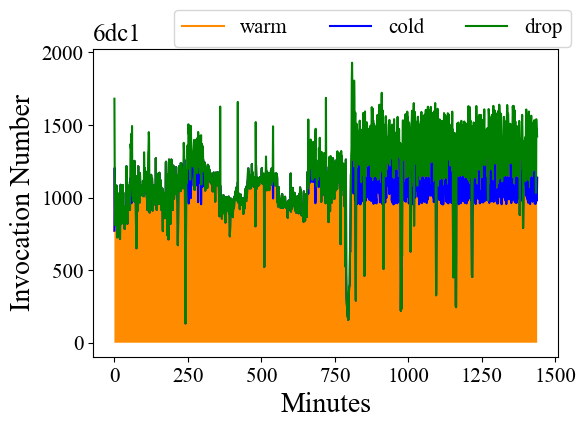

<Figure size 640x480 with 0 Axes>

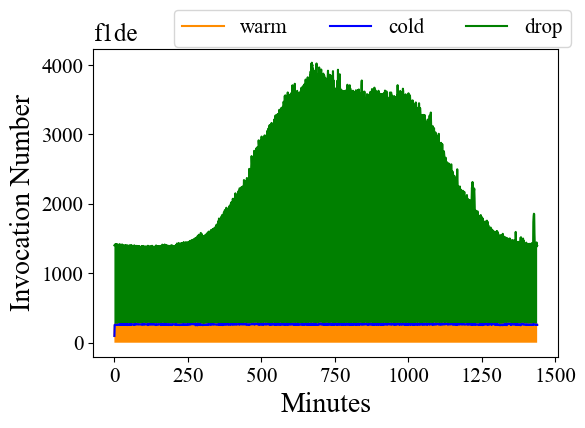

<Figure size 640x480 with 0 Axes>

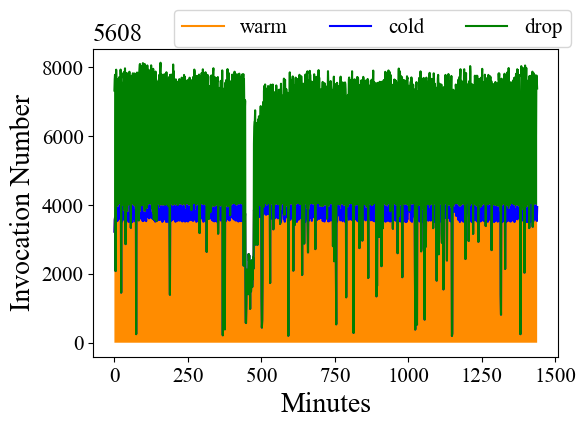

<Figure size 640x480 with 0 Axes>

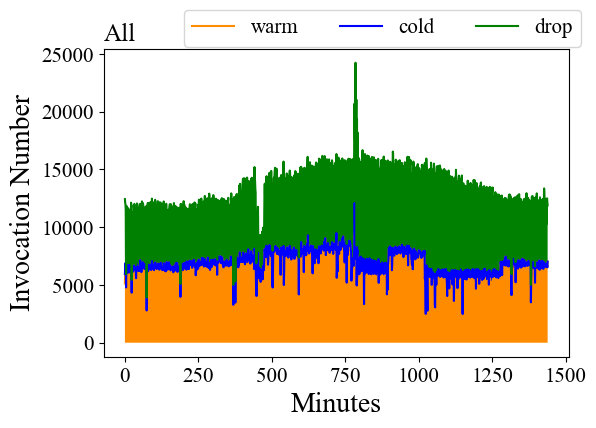

<Figure size 640x480 with 0 Axes>

In [11]:
#三个函数分别独立分配了其所需内存一倍的空间后每分钟warm，cold，drop图
#高频函数在1-1440分钟每分钟热启动，冷启动和超时的次数
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.rc('font',family='Times New Roman')
plt.rc('font',size = 15)
names =["6dc157fa79f808bd7cf577af09efaee2dad035d658e549d4219e705a181d8917",
        "f1de419dc75ea0f629deaf936e0b65934cbf2bc444ffd7b3116e3a19dd108f11",
        "5608f70ad5c4f89e83b01f37bdabd7b89f79338b34776128d68676d83cd3de15",
        "All"
        ]

def read1440Data(df:pd.DataFrame, name:str, suffix:str):
    row_index = name + suffix
    vals = df.loc[row_index,"0":"1439"].values
    return vals

df = pd.read_csv("C:/Users/Administrator/Desktop/Cloud/drawDataSets/10ms_simple_allocate/SSMP/perMinute16G.csv")

X = np.array([i for i in range(1440)])

df["full_name"] = df.apply(lambda row: row['name'] + row['state'], axis=1)
df.index = df["full_name"]

index = 0
for name in names:
    perMinWarm = read1440Data(df,name,"Warm")
    perMinCold = read1440Data(df,name,"Cold")
    perMinDrop = read1440Data(df,name,"TTLDrop")
    warm = perMinWarm
    cold = np.add(warm,perMinCold)
    drop = np.add(cold,perMinDrop)
    
    
    fig,axe = plt.subplots(figsize=(6,4),dpi=100)
    axe.set_xlabel('Minutes',fontproperties = 'Times New Roman', size = 20)
    axe.set_ylabel('Invocation Number',fontproperties = 'Times New Roman', size = 20)
    title = name[0:3]
    if len(name) > 3 :
        title = name[0:4]
    axe.set_title(title,loc='left')
    
    axe.plot(X,warm,"darkorange")
    axe.plot(X,cold,"blue")
    axe.plot(X,drop,"g")

    axe.fill_between(X.tolist(),0,warm.tolist(),facecolor = 'darkorange')
    axe.fill_between(X.tolist(),warm.tolist(),cold.tolist(),facecolor = 'blue')
    axe.fill_between(X.tolist(),cold.tolist(),drop.tolist(),facecolor = 'green')
    plt.legend(labels = ('warm','cold','drop'),ncol=3 ,loc = 'upper center',bbox_to_anchor=(0.6,1.16),fontsize = 15)
    plt.savefig('../Pics/high_freq_two_piece_1440'+ title +'.pdf',bbox_inches = 'tight')
    plt.show()
    plt.clf()
    
    index = index + 1


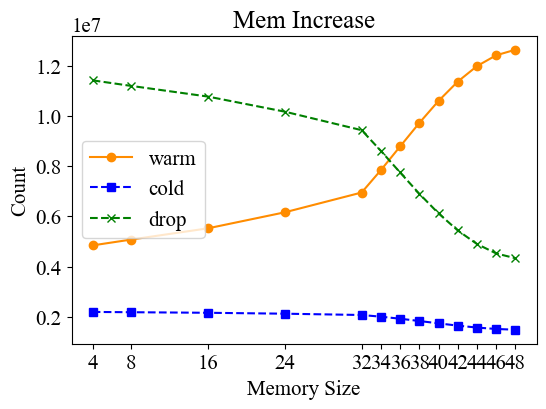

In [87]:
#容器池可用空间从4G增长到48G过程中总体的超时次数
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FixedLocator
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d

plt.rc('font',family='Times New Roman')
plt.rc('font',size = 15)
mems = [4,8,16,24,32,34,36,38,40,42,44,46,48]
warms = [594084,1184047,1917899,2361121,4601661,7400773,10673095,10707497, 13365943, 13392246, 14606537, 14657362, 18410182]
colds = [1079819,1645453, 2578936, 3351776, 3413849, 2780530, 2034624, 2106434, 1479675, 1525864, 1211716, 1233154, 37442]
drops = [16778770,15623173,13955838,12739776,10437163,8271370,5744954,5638742,3607055,3534563,2634420,2562157,5049]

fig,ax = plt.subplots(figsize=(6,4),dpi=100)

warm_smoothed = gaussian_filter1d(warms, sigma=5)
cold_smoothed = gaussian_filter1d(colds, sigma=5)
drop_smoothed = gaussian_filter1d(drops, sigma=5)

ax.set_title('Mem Increase')
ax.set_xlabel('Memory Size')
ax.set_ylabel('Count')
ax.plot(mems,warm_smoothed,'o-',color = 'darkorange')
ax.plot(mems,cold_smoothed,'s--',color = 'blue')
ax.plot(mems,drop_smoothed,'x--',color = 'green')
ax.xaxis.set_major_locator(FixedLocator(mems))
ax.legend(labels = ['warm','cold','drop'])

plt.savefig('../Pics/LRU_mem_4_to_18.pdf',bbox_inches = 'tight')

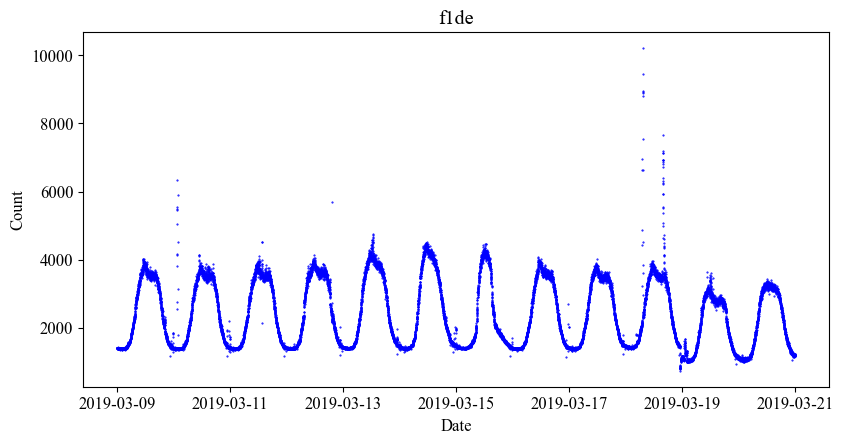

<Figure size 640x480 with 0 Axes>

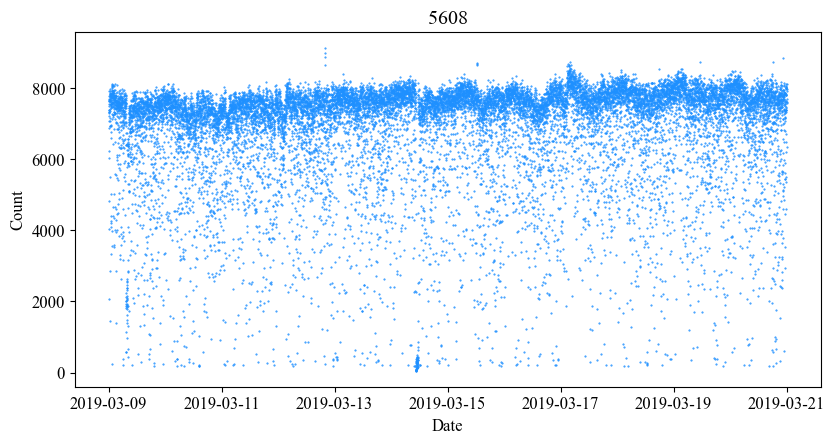

<Figure size 640x480 with 0 Axes>

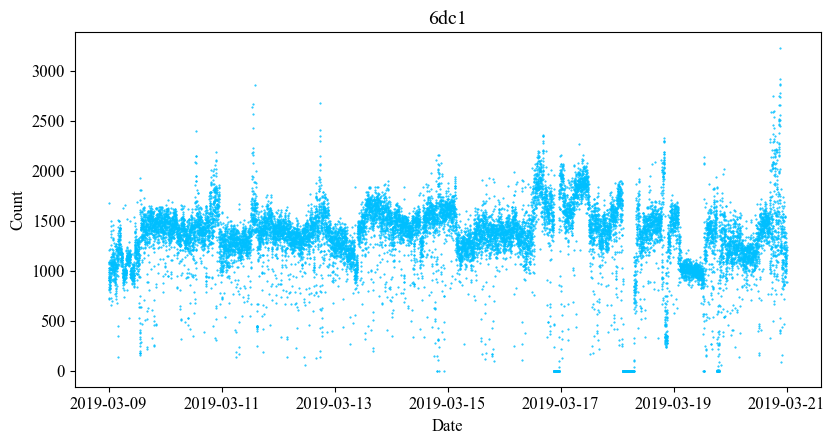

<Figure size 640x480 with 0 Axes>

In [18]:
#三个函数12天的调用次数变化
import pandas as pd
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from prophet import Prophet

plt.rc('font',family='Times New Roman')
plt.rc('font',size = 12)
datapath = "C:\\Users\\Administrator\\Desktop\\Cloud\\Azure2019Data\\Azure2019\\"
invocation_prefix = "invocations_per_function_md.anon"
suffixes = [".d01.csv",".d02.csv",".d03.csv",".d04.csv",".d05.csv",".d06.csv",
            ".d07.csv",".d08.csv",".d09.csv",".d10.csv",".d11.csv",".d12.csv"]
high_cost_function_names = ["f1de419dc75ea0f629deaf936e0b65934cbf2bc444ffd7b3116e3a19dd108f11",
                            "5608f70ad5c4f89e83b01f37bdabd7b89f79338b34776128d68676d83cd3de15",
                            "6dc157fa79f808bd7cf577af09efaee2dad035d658e549d4219e705a181d8917"]

pick_res_path = "D:\\data\\representative\\highcost_invocations"
prediction_res_path = "D:\\data\\representative\\prediction_results"

has_csv_data = True

#获取所有highCost函数一天的数据
def get_one_day_data(path:str, backup:pd.DataFrame):
    invocations = pd.read_csv(path)
    invocations = invocations.dropna()
    invocations.index = invocations["HashFunction"]
    functions = []
    notFoundFuncs = []
    for name in high_cost_function_names:
        if name in invocations.index.values:
            functions.append(name)
        else:
            notFoundFuncs.append(name)
    all_func_data = invocations.loc[functions]
    notFoundData = backup.loc[notFoundFuncs]
    all_func_data:pd.DataFrame = pd.concat([all_func_data,notFoundData])
    return all_func_data

#从csv中读取数据，将一个函数12天的数据全部存放在一个array中返回
def readDataFromCSV(name:str):
    vals = []
    for suffix in suffixes:
        one_day_data_path = os.path.join(pick_res_path,"invocations"+suffix)
        df = pd.read_csv(one_day_data_path)
        df.index = df["HashFunction"]
        val = df.loc[name,"1":"1440"]
        val = val.values.tolist()
        vals = np.append(vals,val)
    return vals

#从内存df数组中读取数据，将一个函数12天的数据全部存放在一个array中返回
def readDataFromMemory(name:str, dfs:list[pd.DataFrame]):
    vals = []
    for df in dfs:
        val = df.loc[name,"1":"1440"]
        val = val.values.tolist()
        vals = np.append(vals,val)
    return vals

#存储上一天的数据。如果某天某函数数据缺失，采用第一天的数据作为备份
#在数据集中第六天3a7e函数数据缺失，这里使用第一天的数据作为替代
backup_data = pd.read_csv(os.path.join(datapath,invocation_prefix+suffixes[0]))
backup_data.dropna()
backup_data.index = backup_data["HashFunction"]

daily_datas = list[pd.DataFrame]
if has_csv_data == False:
    #1.挑出每天高频函数的invocation信息并存储在csv中 TODO:可以放在内存中，不做CSV保存
    for day_suffix in suffixes:
        file_path = os.path.join(datapath, invocation_prefix+day_suffix)
        res_path = os.path.join(pick_res_path,"invocations"+day_suffix)
        data_for_a_day = get_one_day_data(file_path,backup_data)
        daily_datas.append(data_for_a_day)
        data_for_a_day.to_csv(res_path)

columns = []
columns.append("HashFunction")
for i in range(1,1441): columns.append(i)

colors = ['b','dodgerblue','deepskyblue']
index = 0
for func_name in high_cost_function_names:
    if has_csv_data == True:
        data = readDataFromCSV(func_name)
    # 将数据转换为pandas的时间序列,假设第一天为2019-03-09
    dates = pd.date_range('2019-03-09', periods=len(data), freq='min')
    #series = pd.Series(data=data)
    df = pd.DataFrame({'ds':dates,'y':data})
    fig,ax = plt.subplots(figsize=(8,4),dpi=100)
    fig.tight_layout(pad=0.4, w_pad=0, h_pad=2)
    ax.scatter(dates,data,s=1,marker= '.' ,c = colors[index] )
    ax.set_ylabel('Count')
    ax.set_title(func_name[0:4])
    ax.set_xlabel('Date')

    plt.savefig('../Pics/12_day_trend'+ func_name[0:4] + '.pdf',bbox_inches = 'tight')
    plt.show()
    plt.clf()
    index = index + 1

# fig.legend(labels = [ name[0:4] for name in high_cost_function_names],ncols = 3,loc = 'upper center',
#         bbox_to_anchor=(0.5,0.9))
    


In [ ]:
#FaaS架构图
#理想情境下的分析图
#内存争用分析图
#修改后的系统架构图
#数据集表

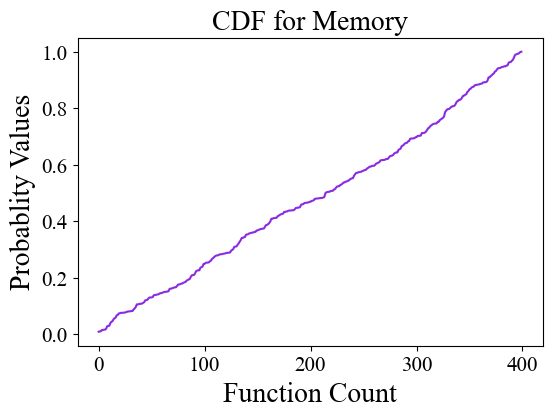

<Figure size 640x480 with 0 Axes>

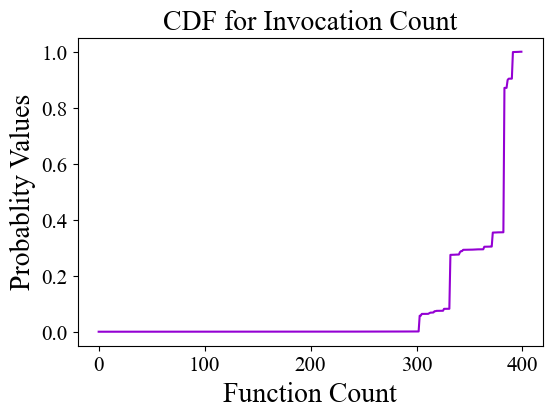

<Figure size 640x480 with 0 Axes>

In [4]:
#400个函数内存与调用频次CDF图
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FixedLocator
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
plt.rc('font',family='Times New Roman')
plt.rc('font',size = 15)
data = pd.read_csv("C:/Users/Administrator/Desktop/Cloud/drawDataSets/representative/functions.csv")
X = [i for i in range(400)]

mems = data["divvied"]
counts = data['Count']
mem_pdf = mems/np.sum(mems)
mem_cdf = np.cumsum(mem_pdf)

counts_pdf = counts/np.sum(counts)
counts_cdf = np.cumsum(counts_pdf)

fig,ax = plt.subplots(1,1,figsize=(6,4),dpi=100)
ax.plot(X,mem_cdf,color = 'blueviolet')
ax.set_xlabel('Function Count',size=20)
ax.set_ylabel('Probablity Values',size=20)
ax.set_title('CDF for Memory',size=20)
plt.savefig('../Pics/mem_cdf.pdf',bbox_inches = 'tight')
plt.show()
plt.clf()

fig,ax = plt.subplots(1,1,figsize=(6,4),dpi=100)
ax.plot(X,counts_cdf,color = 'darkviolet')
ax.set_xlabel('Function Count',size=20)
ax.set_ylabel('Probablity Values',size=20)
ax.set_title('CDF for Invocation Count',size=20)
plt.savefig('../Pics/count_cdf.pdf',bbox_inches = 'tight')
plt.show()
plt.clf()



C:\Users\Administrator\AppData\Local\Temp\ipykernel_18676\1064308736.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(mems,hist=True,kde=True,color='royalblue')


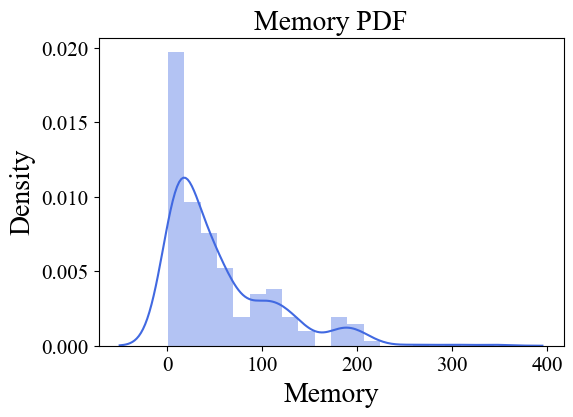

In [91]:
#内存和调用次数pdf图
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FixedLocator
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
plt.rc('font',family='Times New Roman')
plt.rc('font',size = 15)
data = pd.read_csv("C:/Users/Administrator/Desktop/Cloud/drawDataSets/representative/functions.csv")


mems = data["divvied"]
counts = data['Count']
plt.figure(dpi=100, figsize=(6, 4))
sns.distplot(mems,hist=True,kde=True,color='royalblue')
plt.ylabel("Density",size=20)

plt.xlabel('Memory',size=20)
plt.title('Memory PDF',size=20)


#fig.tight_layout(pad=0.4, w_pad=1, h_pad=1.5)
plt.savefig('../Pics/mem_pdf.pdf',bbox_inches = 'tight')

15:53:30 - cmdstanpy - INFO - Chain [1] start processing
15:53:44 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Administrator\AppData\Local\Temp\ipykernel_18676\3436386483.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_res['yhat'] = forecast_res['yhat'].astype(int)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_18676\3436386483.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_res['yhat_lower'] = forecast_res['yhat_lower'].astype(int)
C:\Users\Administrator\AppDat

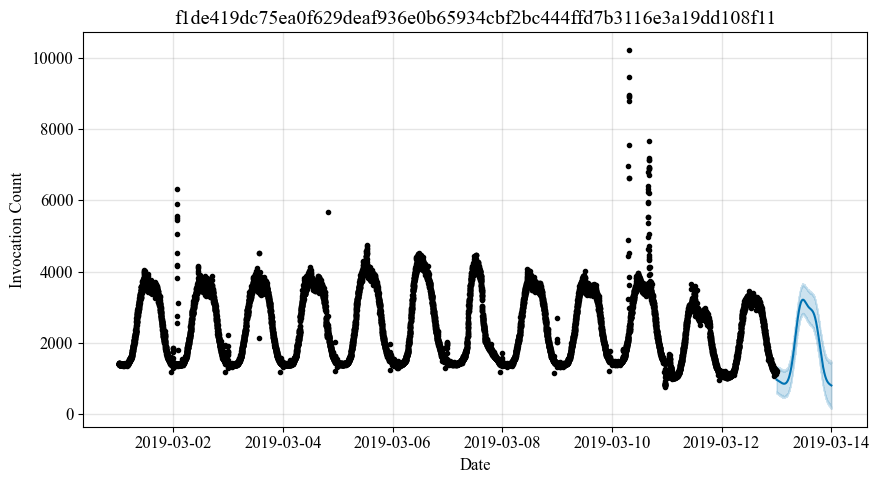

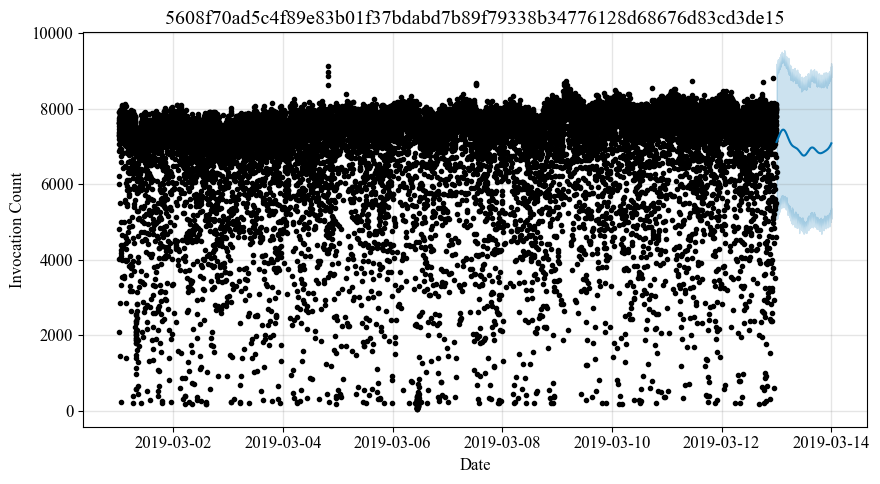

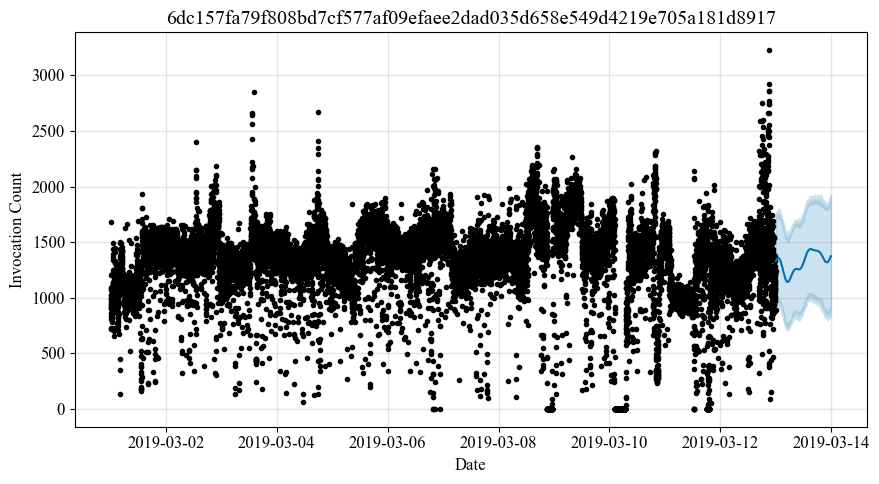

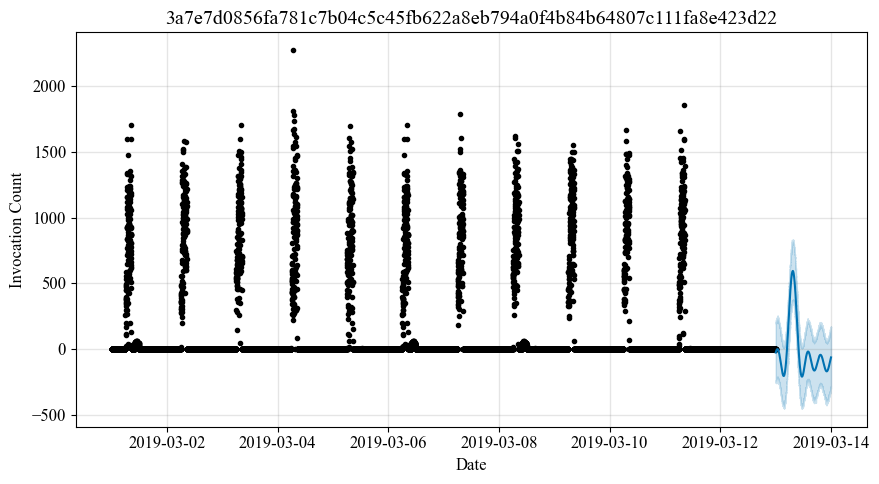

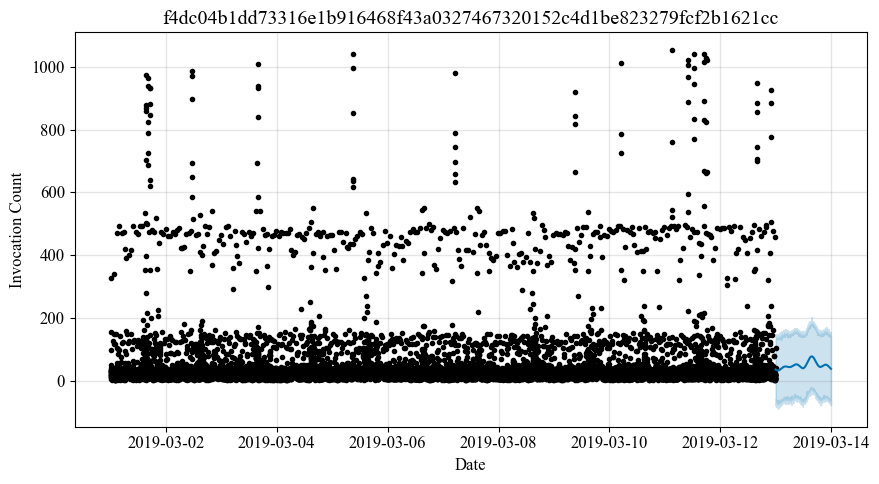

In [64]:
#预测图
import pandas as pd
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from prophet import Prophet

plt.rc('font',family='Times New Roman')
plt.rc('font',size = 12)
datapath = "C:\\Users\\Administrator\\Desktop\\Cloud\\Azure2019Data\\Azure2019\\"
invocation_prefix = "invocations_per_function_md.anon"
suffixes = [".d01.csv",".d02.csv",".d03.csv",".d04.csv",".d05.csv",".d06.csv",
            ".d07.csv",".d08.csv",".d09.csv",".d10.csv",".d11.csv",".d12.csv"]
high_cost_function_names = ["f1de419dc75ea0f629deaf936e0b65934cbf2bc444ffd7b3116e3a19dd108f11",
                            "5608f70ad5c4f89e83b01f37bdabd7b89f79338b34776128d68676d83cd3de15",
                            "6dc157fa79f808bd7cf577af09efaee2dad035d658e549d4219e705a181d8917",
                            "3a7e7d0856fa781c7b04c5c45fb622a8eb794a0f4b84b64807c111fa8e423d22",
                            "f4dc04b1dd73316e1b916468f43a0327467320152c4d1be823279fcf2b1621cc"]

pick_res_path = "D:\\data\\representative\\highcost_invocations"
prediction_res_path = "D:\\data\\representative\\prediction_results"

has_csv_data = True

#获取所有highCost函数一天的数据
def get_one_day_data(path:str, backup:pd.DataFrame):
    invocations = pd.read_csv(path)
    invocations = invocations.dropna()
    invocations.index = invocations["HashFunction"]
    functions = []
    notFoundFuncs = []
    for name in high_cost_function_names:
        if name in invocations.index.values:
            functions.append(name)
        else:
            notFoundFuncs.append(name)
    all_func_data = invocations.loc[functions]
    notFoundData = backup.loc[notFoundFuncs]
    all_func_data:pd.DataFrame = pd.concat([all_func_data,notFoundData])
    return all_func_data

#从csv中读取数据，将一个函数12天的数据全部存放在一个list中返回
def readDataFromCSV(name:str):
    vals = []
    for suffix in suffixes:
        one_day_data_path = os.path.join(pick_res_path,"invocations"+suffix)
        df = pd.read_csv(one_day_data_path)
        df.index = df["HashFunction"]
        val = df.loc[name,"1":"1440"]
        val = val.values.tolist()
        vals = np.append(vals,val)
    return vals

#从内存df数组中读取数据，将一个函数12天的数据全部存放在一个list中返回
def readDataFromMemory(name:str, dfs:list[pd.DataFrame]):
    vals = []
    for df in dfs:
        val = df.loc[name,"1":"1440"]
        val = val.values.tolist()
        vals = np.append(vals,val)
    return vals

#存储上一天的数据。如果某天某函数数据缺失，采用第一天的数据作为备份
#在数据集中第六天3a7e函数数据缺失，这里使用第一天的数据作为替代
backup_data = pd.read_csv(os.path.join(datapath,invocation_prefix+suffixes[0]))
backup_data.dropna()
backup_data.index = backup_data["HashFunction"]

daily_datas = list[pd.DataFrame]
if has_csv_data == False:
    #1.挑出每天高频函数的invocation信息并存储在csv中 TODO:可以放在内存中，不做CSV保存
    for day_suffix in suffixes:
        file_path = os.path.join(datapath, invocation_prefix+day_suffix)
        res_path = os.path.join(pick_res_path,"invocations"+day_suffix)
        data_for_a_day = get_one_day_data(file_path,backup_data)
        daily_datas.append(data_for_a_day)
        data_for_a_day.to_csv(res_path)

columns = []
columns.append("HashFunction")
for i in range(1,1441): columns.append(i)
    
predictions = pd.DataFrame(columns=columns)
for func_name in high_cost_function_names:
    if has_csv_data == True:
        data = readDataFromCSV(func_name)
    # 将数据转换为pandas的时间序列,假设第一天为2019-03-01
    dates = pd.date_range('2019-03-01', periods=len(data), freq='min')
    #series = pd.Series(data=data)
    df = pd.DataFrame({'ds':dates,'y':data})
    model = Prophet()
    model.fit(df)
    future = model.make_future_dataframe(periods=24*60, freq='min', include_history=False)

    # 使用模型预测第13天中每分钟的数据
    forecast = model.predict(future)
    
    #存储预测结果
    forecast_res = forecast[['ds','yhat','yhat_lower','yhat_upper']]
    forecast_res['yhat'] = forecast_res['yhat'].astype(int)
    forecast_res['yhat_lower'] = forecast_res['yhat_lower'].astype(int)
    forecast_res['yhat_upper'] = forecast_res['yhat_upper'].astype(int)
    forecast_res.to_csv(os.path.join(prediction_res_path, func_name+'.csv'))
    
    yhat_data:list = forecast_res["yhat"].values.tolist()
    for i in range(len(yhat_data)):
        if yhat_data[i] < 0:
            yhat_data[i] = 0
    yhat_data.insert(0,func_name)
    predictions.loc[len(predictions)] = yhat_data
    #predictions = predictions.append(pd.DataFrame([yhat_data]),ignore_index = True)
    
    # 打印预测结果
    #print(forecast[['ds', 'yhat']].tail())

    fig, ax = plt.subplots(figsize=(9, 5),dpi = 100)
    ax.set_title(func_name)
    model.plot(forecast, ax=ax,xlabel="Date",ylabel="Invocation Count")
    plt.savefig("../Pics/" + func_name[0:4] + '_prediction.pdf',bbox_inches = 'tight')

#predictions.to_csv(os.path.join(prediction_res_path, "predictions.csv"),index=0)

# 显示图表




In [ ]:
#三个数据集三种方式整体结果对比图
#representative状态下静态/动态分配后五个函数的统计
#统计调用结果图
#内存分配与占用图

[<matplotlib.lines.Line2D object at 0x00000271F240AE30>, <matplotlib.lines.Line2D object at 0x00000271F2408D00>, <matplotlib.lines.Line2D object at 0x00000271F240B730>, <matplotlib.lines.Line2D object at 0x00000271F2409AB0>, <matplotlib.lines.Line2D object at 0x00000271F2408DC0>, <matplotlib.lines.Line2D object at 0x00000271F240B460>, <matplotlib.lines.Line2D object at 0x00000271F24082E0>, <matplotlib.lines.Line2D object at 0x00000271F240AA70>, <matplotlib.lines.Line2D object at 0x00000271F2409C00>]


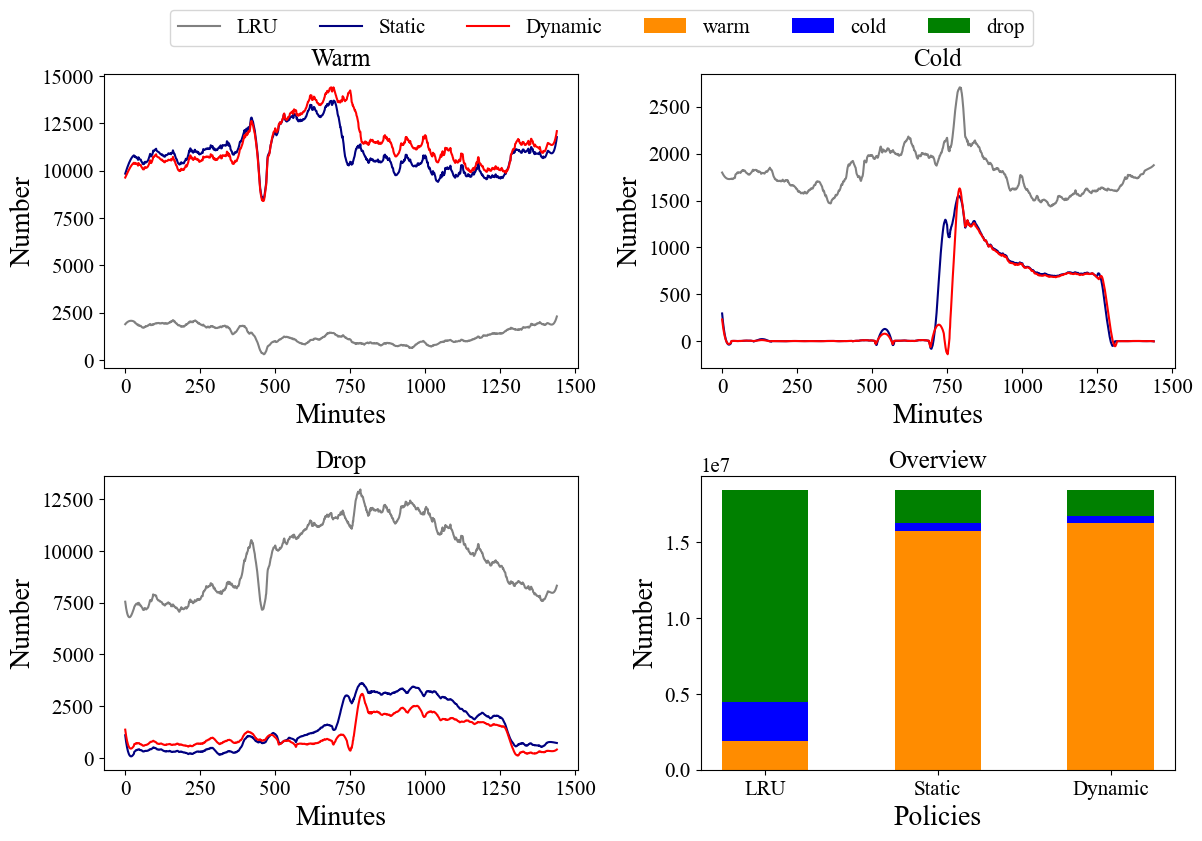

In [96]:
#representative数据集，三种策略每分钟cold，warm，drop折线变化

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter

plt.rc('font',family='Times New Roman')
plt.rc('font',size = 15)
names =["6dc157fa79f808bd7cf577af09efaee2dad035d658e549d4219e705a181d8917",
        "f1de419dc75ea0f629deaf936e0b65934cbf2bc444ffd7b3116e3a19dd108f11",
        "5608f70ad5c4f89e83b01f37bdabd7b89f79338b34776128d68676d83cd3de15",
        "All"
        ]

def read1440Data(df:pd.DataFrame, name:str, suffix:str):
    row_index = name + suffix
    vals = df.loc[row_index,"0":"1439"].values
    return vals

LRUdf = pd.read_csv("C:/Users/Administrator/Desktop/Cloud/10ms/LRU/perMinute16G.csv")
Sdf = pd.read_csv("C:/Users/Administrator/Desktop/Cloud/10ms/SSMP/perMinute16G.csv")
Ddf = pd.read_csv("C:/Users/Administrator/Desktop/Cloud/10ms/DSMP/perMinute16G.csv")

dfs = [LRUdf,Sdf,Ddf]
statelabels = ["Warm","Cold","Drop"]
policyLabels = ["LRU","Static","Dynamic"]
LRUList = []
SList = []
DList = []

WarmSum = []
ColdSum = []
DropSum = []

num = 0
for df in dfs:
    df["full_name"] = df.apply(lambda row: row['name'] + row['state'], axis=1)
    df.index = df["full_name"]
    warm = read1440Data(df,"All","Warm")
    cold = read1440Data(df,"All","Cold")
    drop = read1440Data(df,"All","TTLDrop")
    WarmSum.append(warm.sum())
    ColdSum.append(cold.sum())
    DropSum.append(drop.sum())
    
    if num == 0:
        LRUList = [warm,cold,drop]
        
    if num == 1:
        SList = [warm,cold,drop]
        
    if num == 2:
        DList = [warm,cold,drop]
        
    num = num +1
    
X = np.array([i for i in range(1440)])
fig,ax = plt.subplots(2,2, figsize=(12,8),dpi=100)

handles = []
for i in range(3):
    if i == 0:
        axe =ax[0][0]
    if i == 1:
        axe = ax[0][1]
    if i == 2:
        axe = ax[1][0]
    
    axe.set_xlabel('Minutes',fontproperties = 'Times New Roman', size = 20)
    axe.set_ylabel('Number',fontproperties = 'Times New Roman', size = 20)
    axe.set_title(statelabels[i])
    
    
    handle1, = axe.plot(X,savgol_filter(LRUList[i],60,3),"grey",label = policyLabels[0])
    handle2, = axe.plot(X,savgol_filter(SList[i],60,3),"navy",label = policyLabels[0])
    handle3, = axe.plot(X,savgol_filter(DList[i],60,3),"red",label = policyLabels[0])
    handles = handles + [handle1,handle2,handle3]

axe = ax[1][1]
axe.set_xlabel('Policies',fontproperties = 'Times New Roman', size = 20)
axe.set_ylabel('Number',fontproperties = 'Times New Roman', size = 20)
axe.set_title('Overview')
h1 = axe.bar(policyLabels,WarmSum,width= 0.5,color ="darkorange")
h2 = axe.bar(policyLabels,ColdSum,width= 0.5,color ="blue",bottom=WarmSum)
h3 = axe.bar(policyLabels,DropSum,width= 0.5,color ="green", bottom= [i + j for i,j in zip(WarmSum,ColdSum)])

print(handles)

fig.legend(handles = [handles[0],handles[1],handles[2]] + [h1,h2,h3], labels = policyLabels + ["warm","cold","drop"]
        ,ncols = 6,loc = 'upper center',bbox_to_anchor=(0.5,1.05))
#fig.legend(labels= policyLabels + ["warm","cold","drop"],labelcolor = ['grey','navy','red','darkorange','blue','green'],ncols = 3,loc = 'upper center',bbox_to_anchor=(0.5,1.05))



# plt.legend(labels = ('warm','cold','drop'),ncol=3 ,loc = 'upper center',bbox_to_anchor=(0.5,1.2))
fig.tight_layout(pad=0.4, w_pad=1, h_pad=1)
plt.savefig('../Pics/rep_compare.pdf',bbox_inches = 'tight')

<BarContainer object of 2 artists>

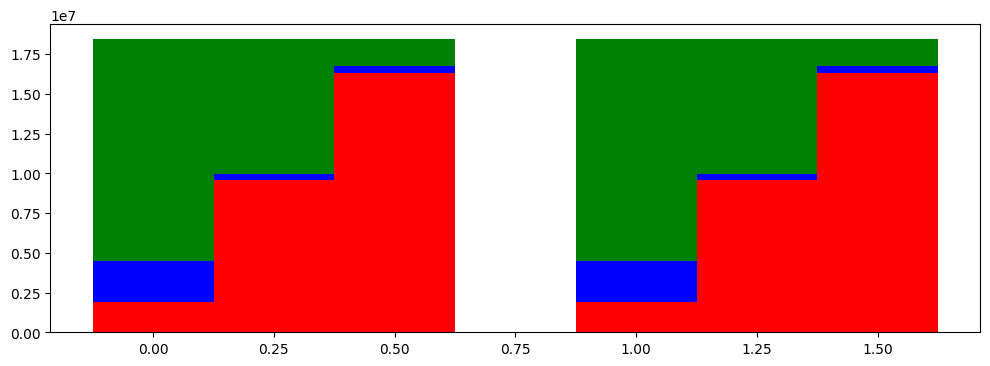

In [90]:
#三个数据集三种方式整体结果对比图
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter

rareLRU = [2482, 3429, 0]





LRUwarm = [1917899,331710]
LRUCold = [2578936,1565840]
LRUDrop = [13955838,12382371]

Swarm = [9601326,9016225]
SCold = [370002,903269]
SDrop = [8481345,4360427]

Dwarm = [16307562,16307562]
DCold = [466585,466585]
DDrop = [1678526,1678526]

fig,ax = plt.subplots(figsize=(12,4),dpi=100)

X = np.arange(2)
ax.bar(X+0.00,LRUwarm,width=0.25,color ='r')
ax.bar(X+0.00,LRUCold,width=0.25,color ='b',bottom=LRUwarm)
ax.bar(X+0.00,LRUDrop,width=0.25,color ='g',bottom=[i+j for i ,j in zip(LRUwarm,LRUCold)])


ax.bar(X+0.25,Swarm,width=0.25,color ='r')
ax.bar(X+0.25,SCold,width=0.25,color ='b',bottom=Swarm)
ax.bar(X+0.25,SDrop,width=0.25,color ='g',bottom=[i+j for i ,j in zip(Swarm,SCold)])

ax.bar(X+0.5,Dwarm,width=0.25,color ='r')
ax.bar(X+0.5,DCold,width=0.25,color ='b',bottom=Dwarm)
ax.bar(X+0.5,DDrop,width=0.25,color ='g',bottom=[i+j for i ,j in zip(Dwarm,DCold)])

In [22]:
#五个高频函数三种策略下调用结果统计
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter


high_cost_function_names = ["f1de419dc75ea0f629deaf936e0b65934cbf2bc444ffd7b3116e3a19dd108f11",
                            "5608f70ad5c4f89e83b01f37bdabd7b89f79338b34776128d68676d83cd3de15",
                            "6dc157fa79f808bd7cf577af09efaee2dad035d658e549d4219e705a181d8917",
                            "3a7e7d0856fa781c7b04c5c45fb622a8eb794a0f4b84b64807c111fa8e423d22",
                            "f4dc04b1dd73316e1b916468f43a0327467320152c4d1be823279fcf2b1621cc"]

LinvokeRecord = "C:/Users/Administrator/Desktop/Cloud/10ms/LRu/invokeRes16G.csv"
SinvokeRecord = "C:/Users/Administrator/Desktop/Cloud/10ms/SSMP/invokeRes16G.csv"
DinvokeRecord = "C:/Users/Administrator/Desktop/Cloud/10ms/DSMP/invokeRes16G.csv"

LRUdf = pd.read_csv(LinvokeRecord)
Sdf = pd.read_csv(SinvokeRecord)
Ddf = pd.read_csv(DinvokeRecord)
dfs = [LRUdf,Sdf,Ddf]

warms = [0,0,0]
colds = [0,0,0]
drops = [0,0,0]
for i in range(len(dfs)):
    for j in range(len(high_cost_function_names)):
        df = dfs[i]
        name = high_cost_function_names[j]
        df.index = df['name']
        warm = df.loc[name,'warm']
        cold = df.loc[name,'cold']
        drop = df.loc[name,'ttl drop']
        
        warms[i] = warms[i] + warm
        colds[i] = colds[i] + cold
        drops[i] = drops[i] + drop
print(warms)
print(colds)
print(drops)
    

[1883333, 13787860, 14204537]
[1483186, 157, 147]
[11647054, 1225556, 808889]


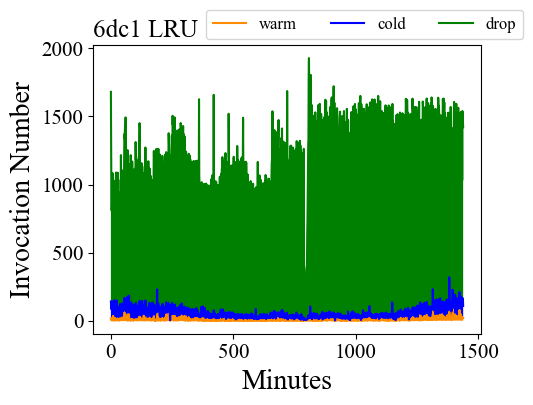

<Figure size 640x480 with 0 Axes>

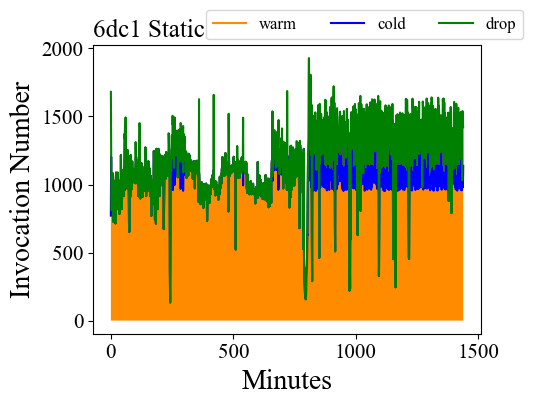

<Figure size 640x480 with 0 Axes>

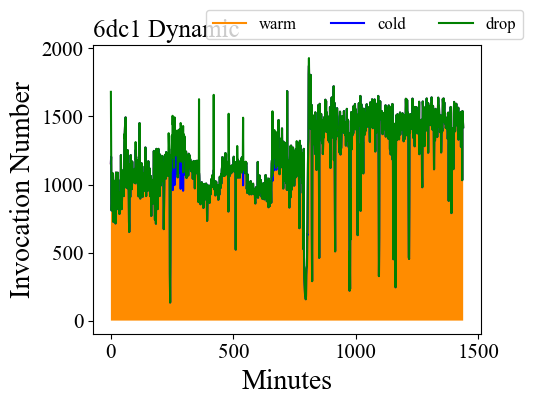

<Figure size 640x480 with 0 Axes>

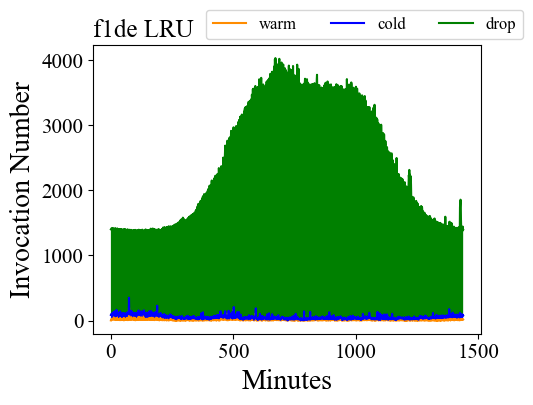

<Figure size 640x480 with 0 Axes>

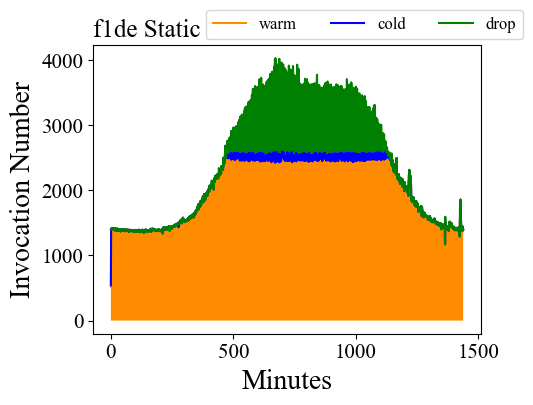

<Figure size 640x480 with 0 Axes>

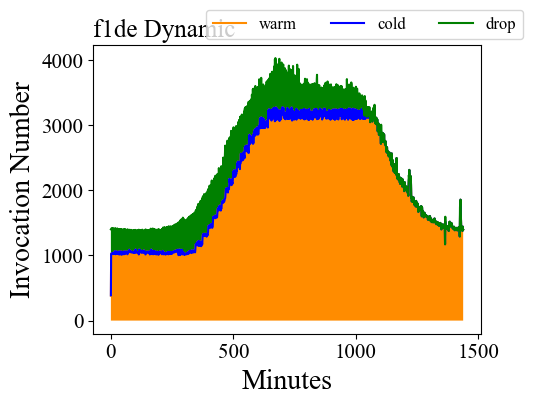

<Figure size 640x480 with 0 Axes>

In [15]:
#f1de,6dc1 1440 分钟统计
#高频函数在1-1440分钟每分钟热启动，冷启动和超时的次数
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.rc('font',family='Times New Roman')
plt.rc('font',size = 15)

names =["6dc157fa79f808bd7cf577af09efaee2dad035d658e549d4219e705a181d8917",
        "f1de419dc75ea0f629deaf936e0b65934cbf2bc444ffd7b3116e3a19dd108f11",
        ]

LPermin = "C:/Users/Administrator/Desktop/Cloud/10ms/LRU/perMinute16G.csv"
SPermin = "C:/Users/Administrator/Desktop/Cloud/10ms/SSMP/perMinute16G.csv"
DPermin = "C:/Users/Administrator/Desktop/Cloud/10ms/DSMP/perMinute16G.csv"
Ldf = pd.read_csv(LPermin)
Sdf = pd.read_csv(SPermin)
Ddf = pd.read_csv(DPermin)
dfs = [Ldf,Sdf,Ddf]

policies = ['LRU','Static','Dynamic']

def read1440Data(df:pd.DataFrame, name:str, suffix:str):
    row_index = name + suffix
    vals = df.loc[row_index,"0":"1439"].values
    return vals


df = pd.read_csv("C:/Users/Administrator/Desktop/Cloud/drawDataSets/representative/results/perMinute.csv")

X = np.array([i for i in range(1440)])

for df in dfs:
    df["full_name"] = df.apply(lambda row: row['name'] + row['state'], axis=1)
    df.index = df["full_name"]

row = 0
for name in names:
    for i in range(len(dfs)):
        df = dfs[i]
        perMinWarm = read1440Data(df,name,"Warm")
        perMinCold = read1440Data(df,name,"Cold")
        perMinDrop = read1440Data(df,name,"TTLDrop")
        warm = perMinWarm
        cold = np.add(warm,perMinCold)
        drop = np.add(cold,perMinDrop)
        fig,axe = plt.subplots( figsize=(5,3.75),dpi=100)
    
        axe.set_xlabel('Minutes',fontproperties = 'Times New Roman', size = 20)
        axe.set_ylabel('Invocation Number',fontproperties = 'Times New Roman', size = 20)
        axe.set_title(name[0:4] + ' ' + policies[i],loc='left')
        
        axe.plot(X,warm,"darkorange")
        axe.plot(X,cold,"blue")
        axe.plot(X,drop,"g")

        axe.fill_between(X.tolist(),0,warm.tolist(),facecolor = 'darkorange')
        axe.fill_between(X.tolist(),warm.tolist(),cold.tolist(),facecolor = 'blue')
        axe.fill_between(X.tolist(),cold.tolist(),drop.tolist(),facecolor = 'green')
        plt.legend(labels = ('warm','cold','drop'),ncol=3 ,loc = 'upper center',bbox_to_anchor=(0.7,1.15),fontsize = 12)
        plt.savefig('../Pics/'+ name[0:4] + policies[i] +'.pdf',bbox_inches = 'tight')
        plt.show()
        plt.clf()

    row = row + 1



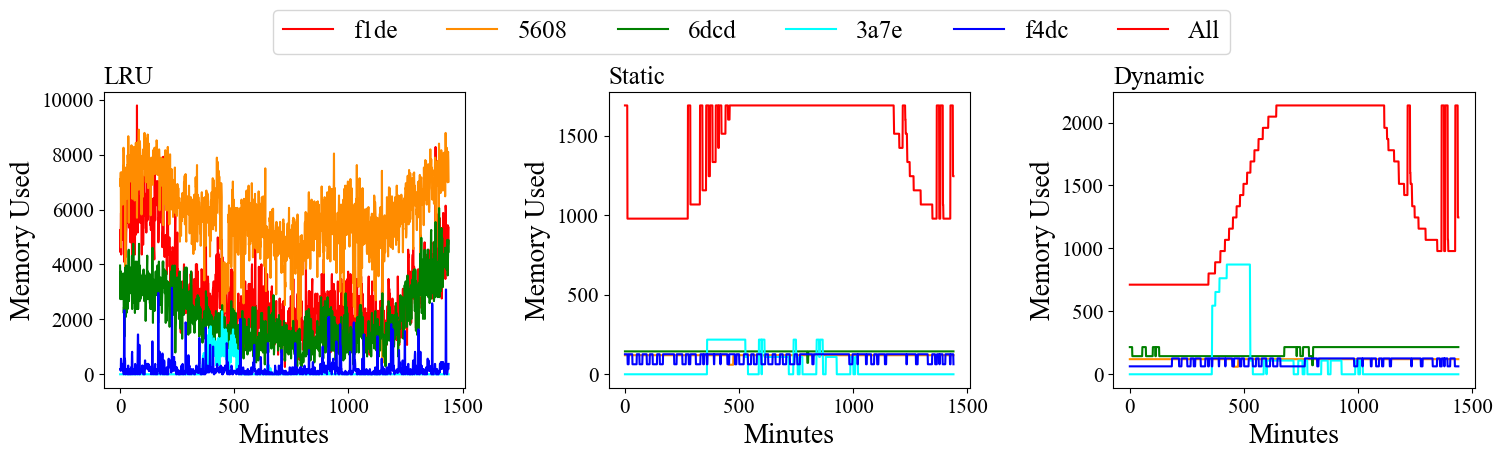

In [102]:
#五个函数内存占用
#高请求函数的容器在1440分钟内每分钟的内存占用
#LRU时每分钟warm，cold，drop图、

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
from scipy.signal import savgol_filter
plt.rc('font',family='Times New Roman')
plt.rc('font',size = 15)

high_cost_function_names = ["f1de419dc75ea0f629deaf936e0b65934cbf2bc444ffd7b3116e3a19dd108f11",
                            "5608f70ad5c4f89e83b01f37bdabd7b89f79338b34776128d68676d83cd3de15",
                            "6dc157fa79f808bd7cf577af09efaee2dad035d658e549d4219e705a181d8917",
                            "3a7e7d0856fa781c7b04c5c45fb622a8eb794a0f4b84b64807c111fa8e423d22",
                            "f4dc04b1dd73316e1b916468f43a0327467320152c4d1be823279fcf2b1621cc"]


def read1440Data(df:pd.DataFrame, name:str, suffix:str):
    row_index = name + suffix
    vals = df.loc[row_index,"0":"1439"].values
    return vals

Ldf = pd.read_csv("C:/Users/Administrator/Desktop/Cloud/10ms/LRU/mem16G.csv")
Sdf = pd.read_csv("C:/Users/Administrator/Desktop/Cloud/10ms/SSMP/mem16G.csv")
Ddf = pd.read_csv("C:/Users/Administrator/Desktop/Cloud/10ms/DSMP/mem16G.csv")
dfs = [Ldf,Sdf,Ddf]

X = np.array([i for i in range(1440)])

for df in dfs:
    df["full_name"] = df.apply(lambda row: row['name'] + row['value'], axis=1)
    df.index = df["full_name"]
    
colors = ['red','darkorange','green','cyan','blue','purple']
fig,ax = plt.subplots(1,3, figsize=(15,4),dpi=100)

for i in range(len(ax)):
    arrays = []
    for name in high_cost_function_names:
        perMinData = read1440Data(dfs[i],name,"Max")
        arrays.append(perMinData)
    # perMinAverage = read1440Data(Ldf,"All","Max")
    # arrays.append(perMinAverage)

    ax[i].set_xlabel('Minutes',fontproperties = 'Times New Roman', size = 20)
    ax[i].set_ylabel('Memory Used',fontproperties = 'Times New Roman', size = 20)
    for (y,color) in zip(arrays,colors):
        ax[i].plot(X,y,color)

ax[0].set_title("LRU",loc='left')
ax[1].set_title("Static",loc='left')
ax[2].set_title("Dynamic",loc='left')


fig.tight_layout(pad=0.4, w_pad=2, h_pad=4)
fig.legend(labels= ['f1de','5608','6dcd','3a7e','f4dc','All'],ncol=6 ,loc = 'upper center',fontsize = 18,bbox_to_anchor=(0.5,1.15))
plt.savefig('../Pics/high_freq_mem_three_policies.pdf',bbox_inches = 'tight')

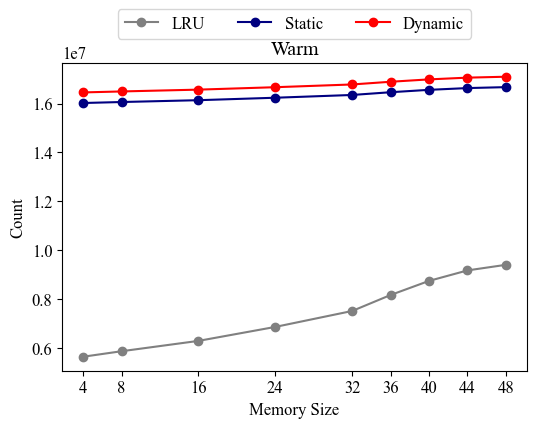

<Figure size 640x480 with 0 Axes>

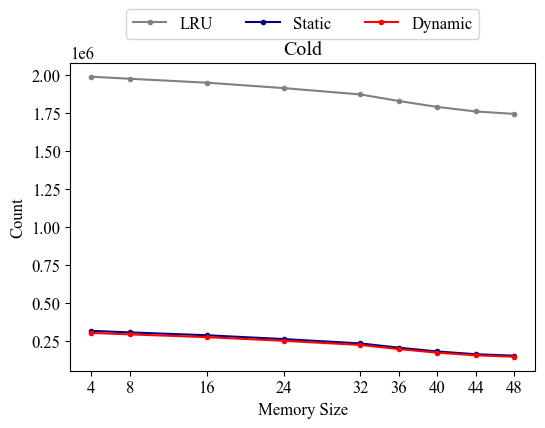

<Figure size 640x480 with 0 Axes>

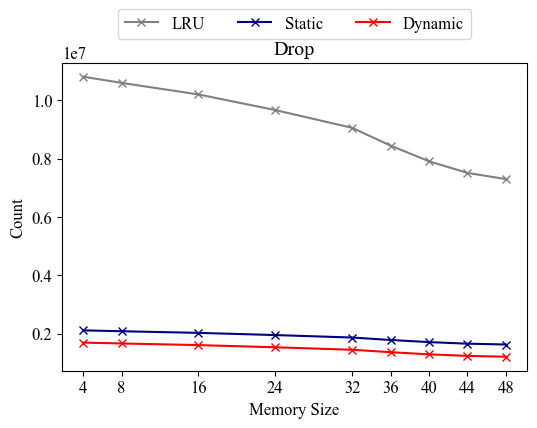

<Figure size 640x480 with 0 Axes>

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FixedLocator
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
plt.rc('font',family='Times New Roman')
plt.rc('font',size = 12)

mems = [4,8,16,24,32,36,40,44,48]
warms = [594084,1184047,1917899,2361121,4601661,10673095, 13365943, 14606537, 18410182]
colds = [1079819,1645453, 2578936, 3351776, 3413849 , 2034624 , 1479675 , 1211716, 37442]
drops = [16778770,15623173,13955838,12739776,10437163,5744954,3607055,2634420,5049]

Swarms = [13995928, 14104211, 15781507, 17181453, 17214579, 17214631,17214650, 17214661,17214692 ]
Scolds = [631139, 900722, 521271, 24803, 12538, 12486,12467, 12456, 12425 ]
Sdrops = [3825606,3447740,2149895,1246417,1225556,1225556,1225556,1225556,1225556]

Dwarms = [14401025,14536774, 16307562, 17598089, 17631254, 17631315, 17631327, 17631350,17631369 ]
Dcolds = [600690, 895255, 466585, 24618, 12530, 12469, 12457, 12434, 12415 ]
Ddrops = [3450958,3020644,1678526,829966,808889,808889,808889,808889,808889]



warm_smoothed = gaussian_filter1d(warms, sigma=5)
cold_smoothed = gaussian_filter1d(colds, sigma=5)
drop_smoothed = gaussian_filter1d(drops, sigma=5)

Swarm_smoothed = gaussian_filter1d(Swarms, sigma=5)
Scold_smoothed = gaussian_filter1d(Scolds, sigma=5)
Sdrop_smoothed = gaussian_filter1d(Sdrops, sigma=5)

Dwarm_smoothed = gaussian_filter1d(Dwarms, sigma=5)
Dcold_smoothed = gaussian_filter1d(Dcolds, sigma=5)
Ddrop_smoothed = gaussian_filter1d(Ddrops, sigma=5)

fig,ax = plt.subplots(figsize=(6,4),dpi=100)
ax.set_title('Warm')
ax.set_xlabel('Memory Size')
ax.set_ylabel('Count')
ax.plot(mems,warm_smoothed,'o-',color = 'grey')
ax.plot(mems,Swarm_smoothed,'o-',color = 'navy')
ax.plot(mems,Dwarm_smoothed,'o-',color = 'red')
ax.xaxis.set_major_locator(FixedLocator(mems))
plt.legend(labels = ['LRU','Static','Dynamic'],ncol=3 ,loc = 'upper center',fontsize = 12,bbox_to_anchor=(0.5,1.2))
plt.savefig('../Pics/mem_4_to_48'+ 'warm.pdf',bbox_inches = 'tight')
plt.show()
plt.clf()


fig,ax = plt.subplots(figsize=(6,4),dpi=100)
ax.set_title('Cold')
ax.set_xlabel('Memory Size')
ax.set_ylabel('Count')
ax.plot(mems,cold_smoothed,'.-',color = 'grey')
ax.plot(mems,Scold_smoothed,'.-',color = 'navy')
ax.plot(mems,Dcold_smoothed,'.-',color = 'red')
ax.xaxis.set_major_locator(FixedLocator(mems))
plt.legend(labels = ['LRU','Static','Dynamic'],ncol=3 ,loc = 'upper center',fontsize = 12,bbox_to_anchor=(0.5,1.2))
plt.savefig('../Pics/mem_4_to_48'+ 'cold.pdf',bbox_inches = 'tight')
plt.show()
plt.clf()


fig,ax = plt.subplots(figsize=(6,4),dpi=100)
ax.set_title('Drop')
ax.set_xlabel('Memory Size')
ax.set_ylabel('Count')
ax.plot(mems,drop_smoothed,'x-',color = 'grey')
ax.plot(mems,Sdrop_smoothed,'x-',color = 'navy')
ax.plot(mems,Ddrop_smoothed,'x-',color = 'red')
ax.xaxis.set_major_locator(FixedLocator(mems))
plt.legend(labels = ['LRU','Static','Dynamic'],ncol=3 ,loc = 'upper center',fontsize = 12,bbox_to_anchor=(0.5,1.2))
plt.savefig('../Pics/mem_4_to_48'+ 'drop.pdf',bbox_inches = 'tight')
plt.show()
plt.clf()


